In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
blue, green, red = sns.color_palette()[:3]

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, precision_recall_curve
from sklearn.calibration import CalibratedClassifierCV
%matplotlib inline

In [2]:
# CONSTANTS
DATA_PATH = '../resources/model_datasets.npz'

# Results

### Load the data

In [3]:
# Extract the arrays from the NPZ file
with np.load(DATA_PATH, allow_pickle=True) as npz: 
    X_train = npz['X_train'] 
    X_test = npz['X_test']
    y_train = npz['y_train']
    y_test = npz['y_test']
    Ids_train = npz['Ids_train']
    Ids_test = npz['Ids_test']
    candidates = npz['candidates']
    candidate_ids = npz['candidate_ids']
    feature_names = npz['feature_names']
    label_names = npz['label_names']
    
# Check shapes
print('Training set shape:', X_train.shape, y_train.shape)
print('Test set shape:', X_test.shape, y_test.shape)

# Label counts
pd.DataFrame({
    'count': pd.value_counts(y_train), 
    'normalized': pd.value_counts(y_train, normalize=True)}
)

Training set shape: (3000, 21) (3000,)
Test set shape: (898, 21) (898,)


,count,normalized
0,1761,0.587
1,1239,0.413


### Get the results of each models

We will load the best models of each kind and evaluate them on the test set :

In [5]:
# Best model filenames
filenames = {
    'decision tree': '../resources/best_models/decision_tree.npy',
    'random forest': '../resources/best_models/random_forest.npy',
    'k-NN': '../resources/best_models/knn.npy',
    'logistic regression': '../resources/best_models/logistic_regression.npy',
    'svm linear': '../resources/best_models/svm_linear.npy',
    'svm rbf': '../resources/best_models/svm_rbf.npy',
}

# Structure to store the results
results = {
    'Model': [],
    'TN': [],
    'FP': [],
    'FN': [],
    'TP': [],
    'Precision': [],
    'Recall': [],
    'Accuracy': [],
    'F1 Score': []
}

# Load each model, get their predictions on the test set and compute the metrics
for key, filename in filenames.items():
    
    # Load the model
    pipe = np.load(filename, allow_pickle=True).item(0)
        
    # Get the predictions on the test set
    y_pred_te = pipe.predict(X_test)
    
    # Get the contingency matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_te).ravel()
    
    # Compute the metrics on the test set
    precision = np.round(precision_score(y_test, y_pred_te), 3)
    recall = np.round(recall_score(y_test, y_pred_te), 3)
    accuracy = np.round(accuracy_score(y_test, y_pred_te), 3)
    f1 = np.round(f1_score(y_test, y_pred_te), 3)
    
    # Save the results
    results['Model'].append(key)
    results['TN'].append(tn)
    results['FP'].append(fp)
    results['FN'].append(fn)
    results['TP'].append(tp)
    results['Precision'].append(precision)
    results['Recall'].append(recall)
    results['Accuracy'].append(accuracy)
    results['F1 Score'].append(f1)
    
# Create a Dataframe from the results dictionary
df = pd.DataFrame.from_items([
    ('Model', results['Model']),
    ('Precision', results['Precision']),
    ('Recall', results['Recall']),
    ('Accuracy', results['Accuracy']),
    ('F1 Score', results['F1 Score']),
    ('TP', results['TP']),
    ('FP', results['FP']),
    ('FN', results['FN']),
    ('TN', results['TN']),
])
df.set_index('Model', inplace=True)

We can present the results in a DataFrame :

In [6]:
# Show the results ordered by descending precision score
df.sort_values('Precision', ascending=False)

,Precision,Recall,Accuracy,F1 Score,TP,FP,FN,TN
Model,,,,,,,,
svm rbf,0.909,0.458,0.757,0.609,170,17,201,510
random forest,0.887,0.844,0.891,0.865,313,40,58,487
k-NN,0.860,0.898,0.898,0.879,333,54,38,473
decision tree,0.819,0.865,0.865,0.841,321,71,50,456
logistic regression,0.811,0.903,0.873,0.855,335,78,36,449
svm linear,0.796,0.927,0.872,0.857,344,88,27,439


And get some scatter plots for easier interpretation :

* Precision VS Recall
* Number of TP VS Number of FP

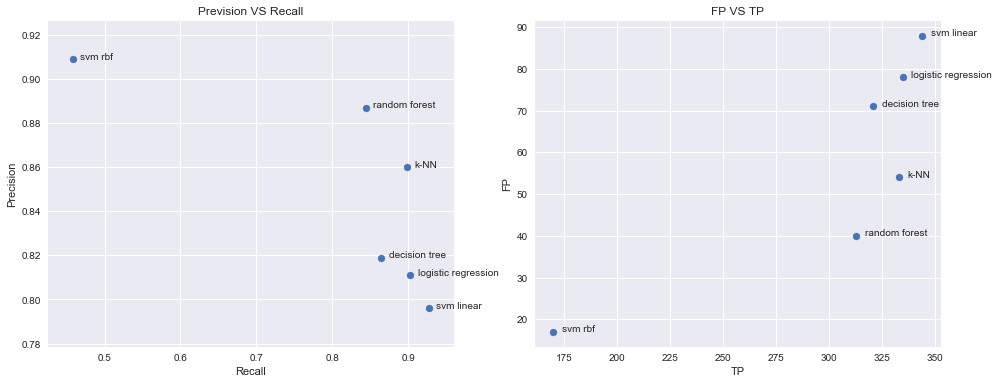

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Precision VS Recall
ax[0].scatter(df['Recall'], df['Precision'])
for i, txt in enumerate(df.index):
    ax[0].annotate(txt, (df['Recall'][i] + 0.01, df['Precision'][i]))  
ax[0].set(xlabel='Recall', ylabel='Precision', title='Prevision VS Recall')

# TP VS FP
ax[1].scatter(df['TP'], df['FP'])
for i, txt in enumerate(df.index):
    ax[1].annotate(txt, (df['TP'][i] + 4, df['FP'][i]))  
ax[1].set(xlabel='TP', ylabel='FP', title='FP VS TP')

plt.show()

The SVM RBF model appears as an outlier and the cost to pay to improve the precision by 2% feels expensive but I think it would be wrong to change our mind now and to favor a more balanced model. If we would like to have the best balanced model, we should tune our models to optimize the F1 Score. This bad feeling explain probably why the F1 Score is often choosen to tune models.

In our case, the precision metric choice was motivated by a scenario in which resources like time and budget are constrained. In such a case, we don't care to miss some positive cases because we will never have the resources to investigate about all of them. The important thing is that the resources are invested as much as possible to positive cases and nothing else. The precision metric is all about that and we have to accept the resulting recall.

A maybe better way to know if this trade-off is acceptable is to put it in front of the use case. Let's say that we have estimated that our time/budget resources will allow us to investigate about 200 exoplanet candidates among the 1'000 in the candidate list. So, to decide we have to:

1. Assess the candidates with our best models
2. Count the number of candidates that have been classified as strong candidates (CONFIRMED) by our best model
3. Conclude :
    * if our SVM RBF model predict that less than 200 candidates are strong candidates, so it can means that it is too much constrained by the precision metric. We could then decide to use the random forest model instead or use it to get the missing candidates
    * if our SVM RBF model predict that more than 200 candidates are strong candidates, it means that we would be happy to have an even more precise model at the cost of an even worse recall.
    
All of that to say that this tradeoff can be acceptable depending our needs. 

So, let's now assess the candidates and next we will experiment with the `predict_proba()` method, the operational probability threshold and the precision-recall curve.

### Candidates Assessment

First, we will load the candidates and drop the candidates that are outside the range defined by the threshold indicator variables engineered during the EDA :

In [8]:
# Create a dataframe from the candidate set
df_candidates = pd.DataFrame(candidates)
df_candidates.columns = feature_names

# filter that join all the engineered threshold indicator variables
f = df_candidates.radius_maxthresh.astype(bool) | \
    df_candidates.ebminusv_maxthresh.astype(bool) | \
    df_candidates.feh_minthresh.astype(bool) | \
    df_candidates.indur_tdur_ratio_maxthresh.astype(bool) | \
    df_candidates.tdur_tperiod_ratio_minthresh.astype(bool) | \
    df_candidates.tdur_tperiod_ratio_maxthresh.astype(bool) | \
    df_candidates.tdepth_minthresh.astype(bool) | \
    df_candidates.tdepth_maxthresh.astype(bool) 


candidates = df_candidates[~f].values
print('Number of candidates: ', candidates.shape[0])

Number of candidates:  823


Note that we could push deeper the selection of the candidates with a specific EDA and/or some insights we get during the EDA, i.e:

* The analysis of the maximum multi-event statistic VS signal-to-noise ration could allow to reject some candidates
* There are more probabilities to find exoplanets around star hosting more TCEs (potential planetery system)
* Etc.

We will not push so far in this project because it will not demonstrate more knowledge than during the EDA but it should be done... 

Let's now assess the remaining candidates with the models :

In [9]:
# Assess the candidates
candidate_predictions = {}
for key, filename in filenames.items():
    
    # Load the model
    pipe = np.load(filename, allow_pickle=True).item(0)
        
    # Get the predictions on the test set
    candidate_predictions[key] = pipe.predict(candidates)

# Create a prediction dataframe
df_candidate_pred = pd.DataFrame.from_dict(candidate_predictions)
df_candidate_pred.head()    

,decision tree,k-NN,logistic regression,random forest,svm linear,svm rbf
0,1,1,1,1,1,0
1,0,0,1,0,1,0
2,1,1,1,1,1,1
3,1,1,1,1,1,1
4,1,1,1,1,1,0


Candidates with a 1 prediction are exoplanets according to the models, let's say strong candidates instead !

In [10]:
# Get some statistics
counts = df_candidate_pred.sum()
counts_percent = (df_candidate_pred.sum() / df_candidate_pred.shape[0] * 100).astype(int)

df_stats = pd.DataFrame({
    'Number of strong candidates': counts, 
    'Percentage %': counts_percent,
    'Precision': df['Precision'],
    'Recall': df['Recall']
})
df_stats.sort_values('Percentage %', ascending=True)

,Number of strong candidates,Percentage %,Precision,Recall
svm rbf,254,30,0.909,0.458
random forest,582,70,0.887,0.844
k-NN,658,79,0.860,0.898
decision tree,680,82,0.819,0.865
logistic regression,708,86,0.811,0.903
svm linear,737,89,0.796,0.927


According to our models and their precision metric:

* The SVM RBF model says that 30% of the candidates are strong candidates, 254 in all, and given its precision score we can expect that 91% of them are really exoplanets and 9% are misclassified exoplanets
* The Random Forest model, our second best model, says that 70% of the candidates are strong candidates, 582 in all. We can expect 89% of them to be exoplanets and 11% to be misclassified exoplanets

If we have time/budget to study less than 254 candidates there is no reason to choose an other model than the SVM RBF model, but what if we have resources to only study, let's say 20 candidates ?

It would be better to know the probability that a candidate is an exoplanet and choose the top 20 candidates with the highest probabilities, right ?

### Optional Experimentation : predict probabilities, operational threshold, precision-recall curve

Except the logistic regression model that is a probablistic model by nature, all other models we have trained aren't. However, we can estimate the probabilities by using some "tricks" and the estimator offers a `predict_proba()` method just for that :

In [11]:
# Assess the candidates and get their probabilities to be exoplanet
candidate_predictions_proba = {}
for key, filename in filenames.items():
    
    # Load the model
    pipe = np.load(filename, allow_pickle=True).item(0)
        
    # Get the candidates probability to be an exoplanet
    if key == 'svm linear':
        # Linear SVC doesn't have a predict_proba method but a decision function one
        # We can use Platt scaling with the CalibratedClassfierCV class to estimate them
        # It would have been better to train our Linear SVM model with the SGD Classifier and hinge loss function
        clc = CalibratedClassifierCV(pipe)
        clc.fit(X_train, y_train)
        candidate_predictions_proba[key] = clc.predict_proba(candidates)[:, 1]
    elif key == 'svm rbf':
        pipe.set_params(svc__probability=True)
        pipe.fit(X_train, y_train)
        candidate_predictions_proba[key] = pipe.predict_proba(candidates)[:, 1]
    else:
        candidate_predictions_proba[key] = pipe.predict_proba(candidates)[:, 1]

We can create a dataframe with the predicted probabilities and sort it to get the 10 candidates with the highest probability according the SVM RBF model :

In [12]:
# Create dataframe with the predicted probabilities by models
df_candidate_proba_pred = pd.DataFrame.from_dict(candidate_predictions_proba)
df_candidate_proba_pred.index = pd.Series(candidate_ids[~f])

df_candidate_proba_pred.sort_values(['svm rbf', 'random forest'], ascending=False).head(10)    

,decision tree,k-NN,logistic regression,random forest,svm linear,svm rbf
K02871.01,0.889553,0.875,0.855888,0.978432,0.798692,1.000000
K01630.01,0.889553,1.000,0.781634,0.976549,0.769461,1.000000
K02106.01,0.889553,0.750,0.882773,0.970285,0.844382,0.999999
K01946.01,0.889553,0.875,0.870109,0.962313,0.823521,0.999999
K02559.01,0.889553,1.000,0.848638,0.981738,0.790955,0.999999
K02620.01,0.889553,0.750,0.850001,0.969664,0.831731,0.999999
K04530.01,0.889553,1.000,0.841102,0.879158,0.762695,0.999999
K01522.02,0.889553,1.000,0.816024,0.987499,0.764868,0.999998
K02972.01,0.889553,0.875,0.763728,0.996791,0.769506,0.999998
K02471.01,0.889553,1.000,0.883424,0.984417,0.844916,0.999998


The meaning of these probabilities are not all equal given the models :

* Decision tree: the predicted class probability is the fraction of samples of the same class in a leaf
* Random forest: the predicted class probabilities of an input sample are computed as the mean predicted class probabilities of the trees in the forest
* k-NN: the predicted class probability is the ratio of the neighbors with the positive class to the k hyperparameter
* SVMs: the predicted class probabilities can only be estimated by training a model with cross-validation on top (wrapping) of the initial pipeline training

Knowing these probabilities, we could now decide that a strong candidate is a candidate with a probability greater than 80% for example instead of the tacit 50% used to tune and select our models. This threshold is called operational threshold. And for each threshold, we can compute the contingency matrix and the derived metrics.

It's common to plot the precision VS threshold, recall VS threshold and the precision-recall curves to compare the models. They give better insights about the model behaviour, capabilities and weaknesses.

To conclude this project, here are these plots for the logistic regression, knn, random forest and SVM with RBF kernel models :

In [27]:
# Predict the probabilities on the test set
y_proba_pred_te = {}
for key, filename in filenames.items():
    
    # Load the model
    pipe = np.load(filename, allow_pickle=True).item(0)
        
    # Get the predictions on the test set
    if key == 'svm linear':
        # Linear SVC doesn't have a predict_proba method but a decision function one
        # We can use Platt scaling with the CalibratedClassfierCV class to estimate them
        # It would have been better to train our Linear SVM model with the SGD Classifier and hinge loss function
        clc = CalibratedClassifierCV(pipe)
        clc.fit(X_train, y_train)
        y_proba_pred_te[key] = clc.predict_proba(X_test)[:, 1]
    elif key == 'svm rbf':
        pipe.set_params(svc__probability=True)
        pipe.fit(X_train, y_train)
        y_proba_pred_te[key] = pipe.predict_proba(X_test)[:, 1]
    else:
        y_proba_pred_te[key] = pipe.predict_proba(X_test)[:, 1]

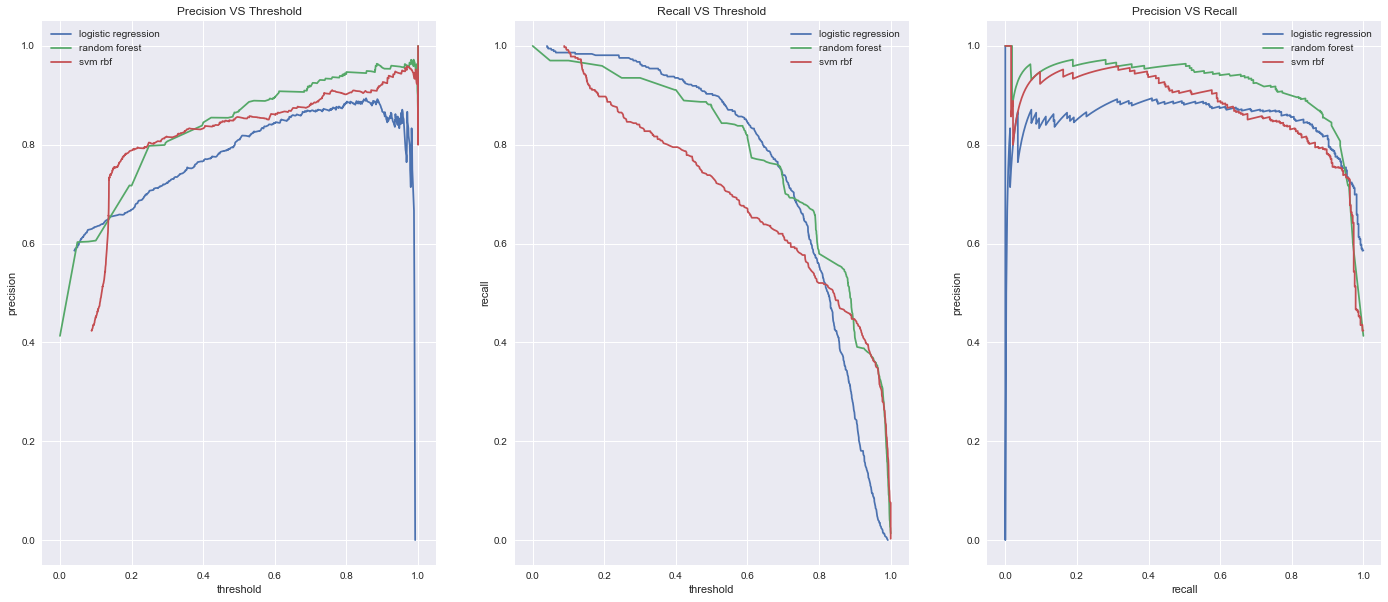

In [33]:
# Get the precision, recall and threshold vectors to plot the Precision-Recall Curve
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(24, 10))
for key in ['logistic regression', 'random forest', 'svm rbf']:
    probabilities = y_proba_pred_te[key]
    precision, recall, thresholds = precision_recall_curve(y_test, probabilities)
    
    # Threshold VS Precision
    ax[0].plot(thresholds, precision[:-1], label=key)
    ax[0].set(xlabel='threshold', ylabel='precision', title='Precision VS Threshold')
    ax[0].legend()
    
    # Threshold VS Recall
    ax[1].plot(thresholds, recall[:-1], label=key)
    ax[1].set(xlabel='threshold', ylabel='recall', title='Recall VS Threshold')
    ax[1].legend()
    
    # Precision VS Recall
    ax[2].plot(recall, precision, label=key)
    ax[2].set(xlabel='recall', ylabel='precision', title='Precision VS Recall')
    ax[2].legend()
    
plt.show()

To be honest, I didn't expected these results and it ask some questions I will need to answer and study on my own after this project.

First of all, the logistic regression model beeing a probabilistic classifier, we can see that its precision metric is much better if we consider an operational threshold near 90% instead the tacit 50% used to tuned and select the model. 

By extension, it means that it probably make no sense to draw this plots now and even less to compare the curves of each models. This job should have been done during the grid search by generating these curves for each models and find the models with the best precision metric and its associated operational threshold.

Given these plots, the SVM RBF model is clearly not the best model but we have to remember that the probabilities, except for the logistic regression models are estimated using some tricks. For the SVM models, the predicted probabilities can even be contradictory with the predicted class. 

- Does it make sense to really use the `predict_proba()` method with model that aren't probabilistic classifier ?
- I experimented with the ROC area under curve metric but for some models like k-NN and random forest, this metric tends to favor high k value or a large number of trees because the bad discretization of the resulting ROC curve if not the case. Sounds not good when the quality of the measure is function of the hyperparameters we want to measure... In such a situation, how to select the model with the best ROC curve or precission-recall curve and be able to scale when we have more than 1'000 models trained by grid-search ?

At this stage, it would not be reasonable to push forward this capstone project but we have open the box and a lot of things could be done to improve our models and also rethink how to build them. Using dense neural networks, combining model predictions would be interesting things to try for example...